## Intro

In this notebook, I want to use machine learning techniques, namely Support Vector Machine, to train a trading model with the aim of capturing abnormal profits in the Chinese stock market. This notebook is just my personal exercise on using Python for finance. This is neither a detailed study of using ML algorithms in the stock market nor is aimed at coming up with a working strategy for trading stocks.

The data used in this project comes from <a href='http://www.gtarsc.com/'>CSMAR</a> financial data services center in China. The stocks are 18 of the biggest Chinese companies listed on <a href='https://en.wikipedia.org/wiki/SSE_50_Index'>Shanghai Stock Exchange 50 Index</a>. These stocks actually constituted a portfolio of my <a href='https://github.com/alisiina/thesis'>bachelors thesis</a> study. The time-perid is from January 2004 up to December 2017. The dataset only contains the daily closing prices of the stocks. The data does not take into account stocks splits.

In [1]:
#import the essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#set default plot size
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
#load the dataset and inspect
data = pd.read_csv('cn_stocks.csv')
data.head()

,Index,Close,Close.1,Close.2,Close.3,Close.4,Close.5,Close.6,Close.7,Close.8,Close.9,Close.10,Close.11,Close.12,Close.13,Close.14,Close.15,Close.16,Close.17
0,2004-01-02,10.50,9.58,7.25,13.67,7.68,5.81,7.80,11.55,5.21,13.80,23.70,25.19,10.88,4.12,5.08,7.98,9.25,16.81
1,2004-01-05,11.03,10.11,7.67,15.04,7.88,6.03,7.84,12.25,5.69,14.00,23.47,26.40,11.38,4.53,5.43,8.27,9.64,17.25
2,2004-01-06,11.36,10.45,7.72,15.17,8.23,5.91,8.15,12.67,5.60,13.86,22.98,26.96,11.79,4.88,5.65,8.38,9.92,17.97
3,2004-01-07,11.56,11.06,7.81,15.00,8.14,6.13,8.09,12.87,5.60,14.03,23.81,26.95,11.93,4.78,5.64,8.65,9.74,18.30
4,2004-01-08,11.63,10.67,7.72,15.27,8.18,6.15,8.30,12.90,5.58,14.65,23.68,27.42,12.05,4.94,5.78,8.67,10.44,17.83


In [3]:
data.dtypes

Index        object
Close       float64
Close.1     float64
Close.2     float64
Close.3     float64
Close.4     float64
Close.5     float64
Close.6     float64
Close.7     float64
Close.8     float64
Close.9     float64
Close.10    float64
Close.11    float64
Close.12    float64
Close.13    float64
Close.14    float64
Close.15    float64
Close.16    float64
Close.17    float64
dtype: object

In [4]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349 entries, 0 to 3348
Data columns (total 19 columns):
Index       3349 non-null object
Close       3349 non-null float64
Close.1     3349 non-null float64
Close.2     3204 non-null float64
Close.3     3242 non-null float64
Close.4     3308 non-null float64
Close.5     2961 non-null float64
Close.6     3236 non-null float64
Close.7     3252 non-null float64
Close.8     3303 non-null float64
Close.9     3284 non-null float64
Close.10    3273 non-null float64
Close.11    3280 non-null float64
Close.12    3278 non-null float64
Close.13    3211 non-null float64
Close.14    3246 non-null float64
Close.15    3271 non-null float64
Close.16    3158 non-null float64
Close.17    3110 non-null float64
dtypes: float64(18), object(1)
memory usage: 497.2+ KB


Index         0
Close         0
Close.1       0
Close.2     145
Close.3     107
Close.4      41
Close.5     388
Close.6     113
Close.7      97
Close.8      46
Close.9      65
Close.10     76
Close.11     69
Close.12     71
Close.13    138
Close.14    103
Close.15     78
Close.16    191
Close.17    239
dtype: int64

We can see that the data contains quite a significant number of missing values in the dataset. But lets visualize the missing data with the wonderful <a href='https://pypi.org/project/missingno/'>missingno</a> module:

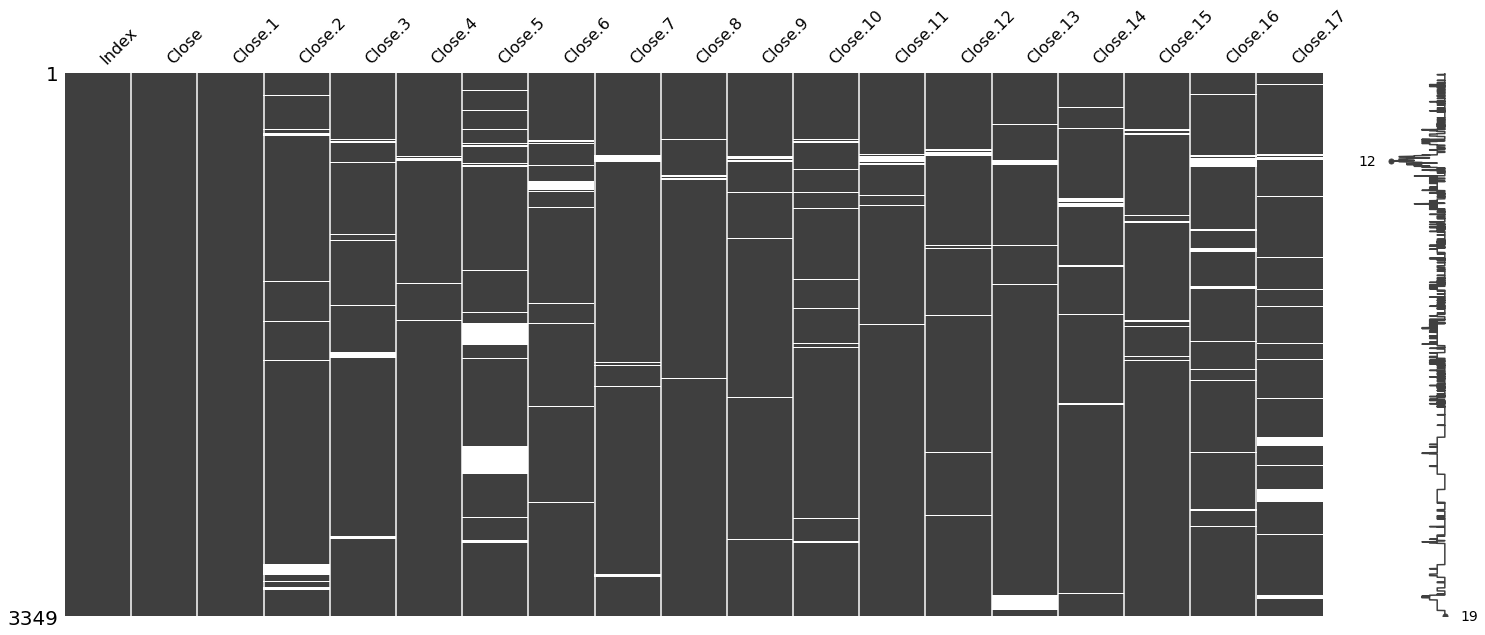

In [5]:
import missingno as msno
msno.matrix(data)

We cannot drop the missing values since this is a continuous time series of stock prices. Filling them with the standard imputation techniques, such as median or mode, does not make much sense either in the context of stock prices over an 18-year period. For such datasets, regression and nearest neighbor imputation methods are more appropriate.

For this dataset, I am choosing <a href='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4959387/'>kNN imputation</a> with the <a href='https://github.com/iskandr/fancyimpute'>fancyimpute</a> library.

In [6]:
import fancyimpute as fi
stocks = fi.KNN(k=8).complete(data.iloc[:, 1:20])
stocks = pd.DataFrame(stocks) #convert array back to dataframe

Using TensorFlow backend.


Imputing row 1/3349 with 0 missing, elapsed time: 2.356
Imputing row 101/3349 with 0 missing, elapsed time: 2.357
Imputing row 201/3349 with 0 missing, elapsed time: 2.358
Imputing row 301/3349 with 0 missing, elapsed time: 2.359
Imputing row 401/3349 with 0 missing, elapsed time: 2.361
Imputing row 501/3349 with 1 missing, elapsed time: 2.364
Imputing row 601/3349 with 1 missing, elapsed time: 2.372
Imputing row 701/3349 with 1 missing, elapsed time: 2.374
Imputing row 801/3349 with 1 missing, elapsed time: 2.376
Imputing row 901/3349 with 0 missing, elapsed time: 2.378
Imputing row 1001/3349 with 1 missing, elapsed time: 2.380
Imputing row 1101/3349 with 1 missing, elapsed time: 2.383
Imputing row 1201/3349 with 0 missing, elapsed time: 2.384
Imputing row 1301/3349 with 0 missing, elapsed time: 2.385
Imputing row 1401/3349 with 0 missing, elapsed time: 2.386
Imputing row 1501/3349 with 1 missing, elapsed time: 2.388
Imputing row 1601/3349 with 1 missing, elapsed time: 2.391
Imputing 

In [7]:
#add the Date column back
stocks = pd.concat([data['Index'], stocks], axis=1)
stocks.head()

,Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2004-01-02,10.50,9.58,7.25,13.67,7.68,5.81,7.80,11.55,5.21,13.80,23.70,25.19,10.88,4.12,5.08,7.98,9.25,16.81
1,2004-01-05,11.03,10.11,7.67,15.04,7.88,6.03,7.84,12.25,5.69,14.00,23.47,26.40,11.38,4.53,5.43,8.27,9.64,17.25
2,2004-01-06,11.36,10.45,7.72,15.17,8.23,5.91,8.15,12.67,5.60,13.86,22.98,26.96,11.79,4.88,5.65,8.38,9.92,17.97
3,2004-01-07,11.56,11.06,7.81,15.00,8.14,6.13,8.09,12.87,5.60,14.03,23.81,26.95,11.93,4.78,5.64,8.65,9.74,18.30
4,2004-01-08,11.63,10.67,7.72,15.27,8.18,6.15,8.30,12.90,5.58,14.65,23.68,27.42,12.05,4.94,5.78,8.67,10.44,17.83


Those stock names are real boring. So lets give them some interesting and cool names. I used the <a href='https://www.namegenerator.biz/wow-name-generator.php'>WoW Name Generator</a> to create random names for the 18 stocks (confession: I have never played WoW myself).

In [8]:
stocks.columns = ['Date', 'Drabona', 'Eladda', 'Nasin', 'Gilvar', 
                'Din', 'Sonja', 'Sarion', 'Zelda', 'Azurehoof',
                'Nietrem', 'Gath', 'Pypina', 'Volodymyr',
                'Ysydda', 'Ronak', 'Ulvila', 'Voorogg', 'Finalien']

In [9]:
#convert the Date column's dtype to datetime and set it as index
stocks['Date'] = pd.to_datetime(stocks['Date'], format='%Y-%m-%d')
stocks.set_index('Date', inplace=True) 

## Exploring with visuals

In [10]:
stocks.describe()

,Drabona,Eladda,Nasin,Gilvar,Din,Sonja,Sarion,Zelda,Azurehoof,Nietrem,Gath,Pypina,Volodymyr,Ysydda,Ronak,Ulvila,Voorogg,Finalien
count,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000
mean,15.629600,7.711568,6.609750,15.333284,25.073235,8.659870,14.908183,22.468809,7.521306,19.547585,14.786078,166.469489,15.076330,5.037361,6.441281,20.337050,16.223294,40.931155
std,9.670934,2.630735,2.944091,7.023454,19.324287,4.622183,11.028785,8.786514,3.723247,7.798969,5.281075,97.501844,7.051982,1.998262,4.339746,17.830696,11.164463,35.468307
min,6.480000,3.490000,3.560000,2.980000,3.390000,3.500000,4.900000,6.630000,3.250000,7.910000,6.010000,25.190000,5.900000,2.200000,2.240000,4.240000,2.440000,6.900000
25%,9.340000,5.800000,4.800000,9.800000,11.220000,5.640000,8.880000,15.490000,5.010000,14.500000,11.030000,101.600000,10.410000,3.400000,3.490000,11.420000,6.520000,18.850000
50%,12.910000,7.400000,5.960000,15.380000,19.990000,7.696952,11.190000,20.490000,6.260000,17.360000,14.390000,164.820000,13.470000,4.880000,5.520000,14.500000,12.210000,33.490000
75%,17.690000,9.120000,7.120000,20.060000,33.120000,9.820000,15.980000,28.990000,8.560000,21.730000,16.980000,205.100000,17.810000,6.260000,7.910000,22.970000,25.230000,46.430000
max,61.590000,17.610000,21.290000,32.690000,98.720000,41.150000,66.450000,51.290000,28.490000,57.710000,50.260000,560.690000,45.470000,13.080000,28.730000,116.520000,62.390000,230.020000


(array([731947., 732677., 733408., 734138., 734869., 735599., 736330.]),
 <a list of 7 Text xticklabel objects>)

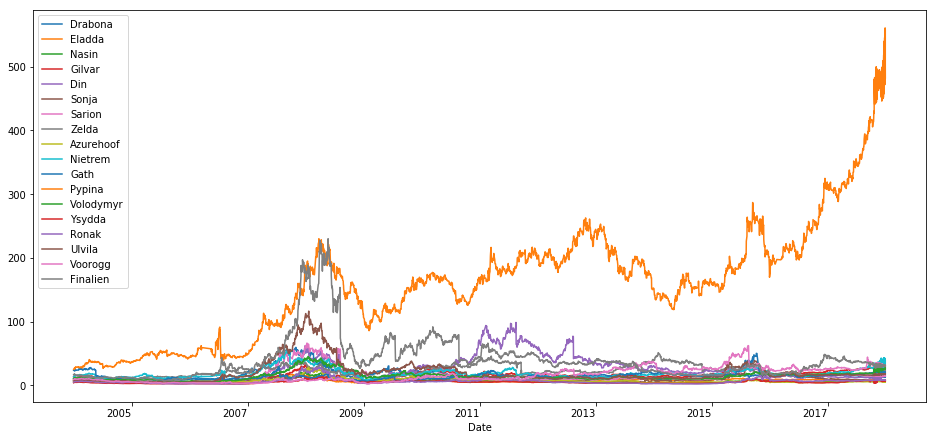

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
stocks.plot(ax=ax)
plt.xticks(rotation=None)

Looks like Pypina is a very good stocks with an exponentialy increasing price. But it's making the time series of other stocks vague. So lets exclude it to see how the other stocks are doing:

(array([731947., 732677., 733408., 734138., 734869., 735599., 736330.]),
 <a list of 7 Text xticklabel objects>)

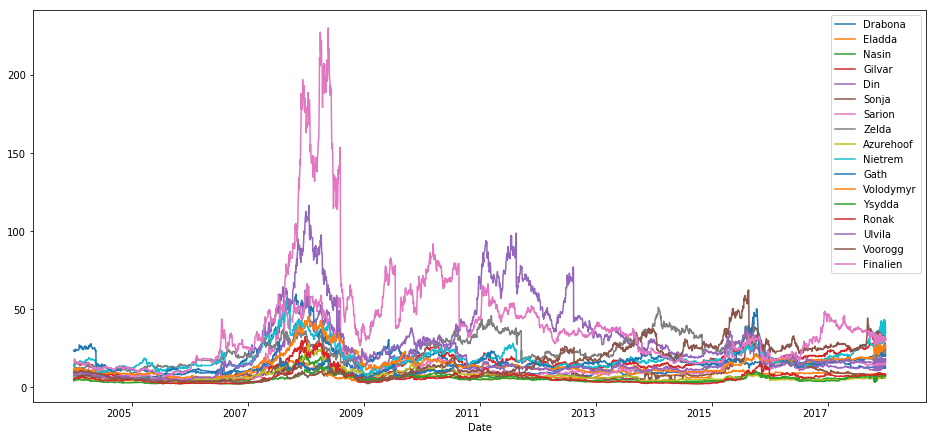

In [12]:
f, ax = plt.subplots(figsize = (16, 8))
stocks.reset_index().plot(x='Date', 
                          y=stocks.columns[stocks.columns != 'Pypina'], ax=ax)
plt.xticks(rotation=None)

Hmm, seems like there is something with wrong with the data right at the end of 2017. A time series for stock prices should not look like that. Lets take a closer look and fix it if possible.

In [13]:
stocks.tail()

,Drabona,Eladda,Nasin,Gilvar,Din,Sonja,Sarion,Zelda,Azurehoof,Nietrem,Gath,Pypina,Volodymyr,Ysydda,Ronak,Ulvila,Voorogg,Finalien
Date,,,,,,,,,,,,,,,,,,
2017-12-25,13.06,8.49,7.28,31.74,15.50,7.66,14.82,28.57,5.86,41.41,20.50,545.54,26.04,7.15,8.28,18.05,30.71,31.20
2017-12-26,13.05,8.54,7.37,32.11,15.28,7.63,14.77,28.49,5.82,42.69,20.51,544.09,26.37,7.32,8.19,18.00,30.98,31.30
2017-12-27,12.94,8.46,7.53,31.97,15.29,7.63,14.83,27.60,5.81,41.44,20.43,556.15,26.20,7.25,8.22,18.00,31.16,31.18
2017-12-28,13.04,8.39,7.61,32.01,15.38,7.50,14.84,27.69,5.81,38.79,20.44,560.69,26.87,7.21,8.16,17.97,30.83,30.58
2017-12-29,12.99,8.39,7.48,31.51,14.98,7.49,14.71,27.90,5.82,38.90,20.35,556.73,27.03,7.21,8.07,17.90,31.11,29.90


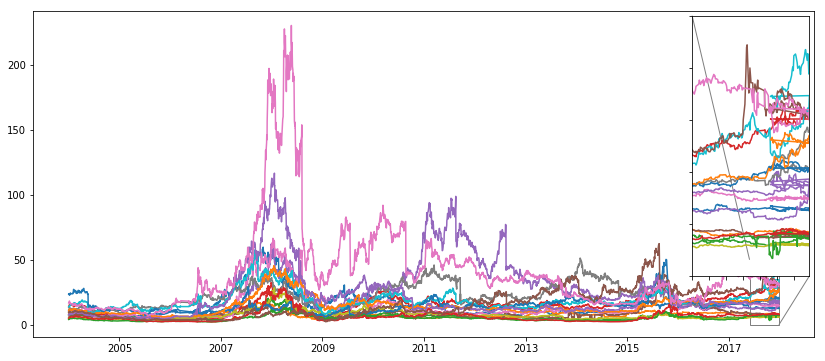

In [14]:
#zoom in on the plot
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#fig, ax = plt.subplots(figsize=(14, 8))
df = stocks.drop(['Pypina'], axis=1)
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
ax.plot(df)
x1 = '2017-06-01'
x2 = '2017-12-29'
y1 = 0
y2 = 50
axins = zoomed_inset_axes(ax, 4, loc=1)
axins.plot(df)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()

(array([731581., 732312., 733042., 733773., 734503., 735234., 735964.,
        736695.]), <a list of 8 Text xticklabel objects>)

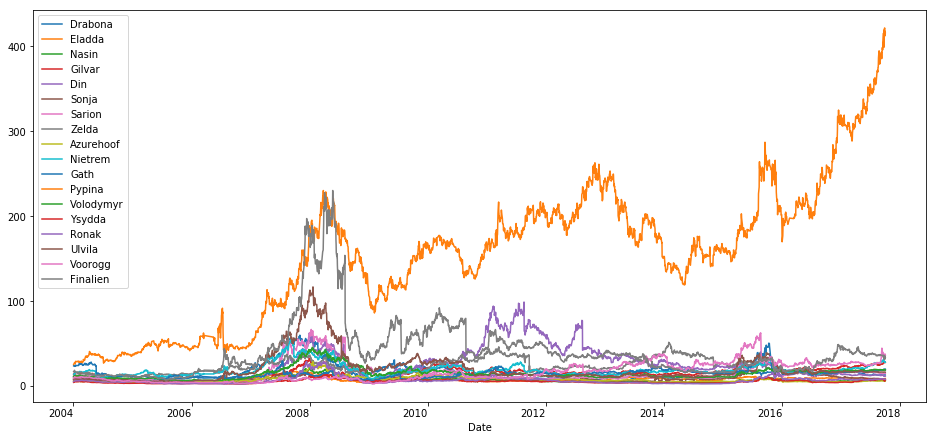

In [15]:
#Fix the data by dropping the last few months for all stocks
fig, ax = plt.subplots(figsize=(16, 8))
stocks = stocks.loc[stocks.index < pd.to_datetime('2017-10-08')]
stocks.plot(ax=ax) ; plt.xticks(rotation=None)

Note that we did not take into account stock splits which is clearly visible in both the plots and the dataset. It's impossible for a single stock price to halve within a day without some market-wide turbulence and continue to steadily climb from the next day. I am not only inferring this from just this fact, but also the data that I gathered listed only closing prices and not adjusted closing prices. For the limited purposes of this notebook, we can ignore this disadvantage for now. But any real trading alogrithm should take into account stock splits.

Lets continue and see if there is any correlation between the stock prices:

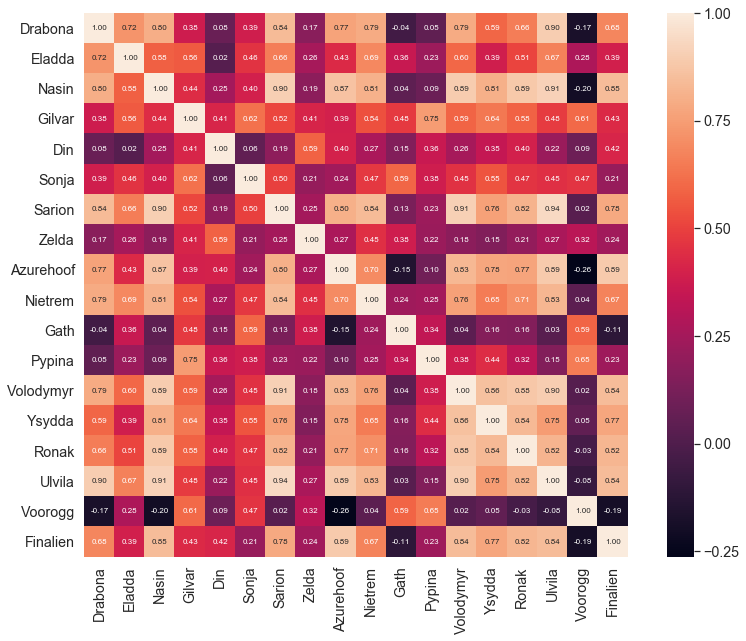

In [16]:
corrmat = stocks.corr()
cm = np.corrcoef(stocks.values.T)
sns.set(font_scale=1.3)
f, ax = plt.subplots(figsize=(14, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size':8},
                 yticklabels=stocks.columns, xticklabels=stocks.columns
                )

Looks like quite a number of stocks' are correlated with each other. In plain English, the heatmap above shows that many of the stocks' prices move in the same direction. But we are not interested in the closing prices of stocks. What we want is to see how the <i>returns</i> of stocks are correlated with each other and whether we can assemble these stocks into a portfolio that is well diversified.

## Calculating returns

In [17]:
#define a function to compute daily returns by getting the daily percent chnage in stock prices
def compute_daily_returns(df):
    daily_returns = df / df.shift(1) - 1
    daily_returns.iloc[0, :] = 0
    return daily_returns

#get the daily returns with the above defined function
returns = compute_daily_returns(stocks)
returns.head()

,Drabona,Eladda,Nasin,Gilvar,Din,Sonja,Sarion,Zelda,Azurehoof,Nietrem,Gath,Pypina,Volodymyr,Ysydda,Ronak,Ulvila,Voorogg,Finalien
Date,,,,,,,,,,,,,,,,,,
2004-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-01-05,0.050476,0.055324,0.057931,0.100219,0.026042,0.037866,0.005128,0.060606,0.092131,0.014493,-0.009705,0.048035,0.045956,0.099515,0.068898,0.036341,0.042162,0.026175
2004-01-06,0.029918,0.033630,0.006519,0.008644,0.044416,-0.019900,0.039541,0.034286,-0.015817,-0.010000,-0.020878,0.021212,0.036028,0.077263,0.040516,0.013301,0.029046,0.041739
2004-01-07,0.017606,0.058373,0.011658,-0.011206,-0.010936,0.037225,-0.007362,0.015785,0.000000,0.012266,0.036118,-0.000371,0.011874,-0.020492,-0.001770,0.032220,-0.018145,0.018364
2004-01-08,0.006055,-0.035262,-0.011524,0.018000,0.004914,0.003263,0.025958,0.002331,-0.003571,0.044191,-0.005460,0.017440,0.010059,0.033473,0.024823,0.002312,0.071869,-0.025683


Text(0.5,1,'% Change in Daily Returns')

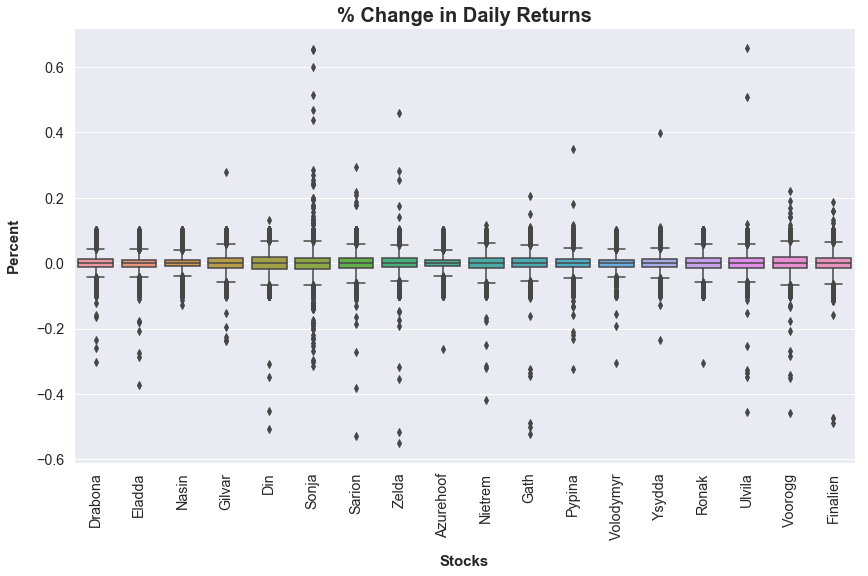

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.set(style='darkgrid', font_scale=1.5)
sns.boxplot(x='variable', y='value', data=pd.melt(returns)).set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.xlabel('Stocks', fontsize=15, fontweight='bold', labelpad=15) 
plt.ylabel('Percent', fontsize=15, fontweight='bold', labelpad=15)
plt.title('% Change in Daily Returns', fontsize=20, fontweight='bold')

Text(0.5,1,'% Change in Daily Returns')

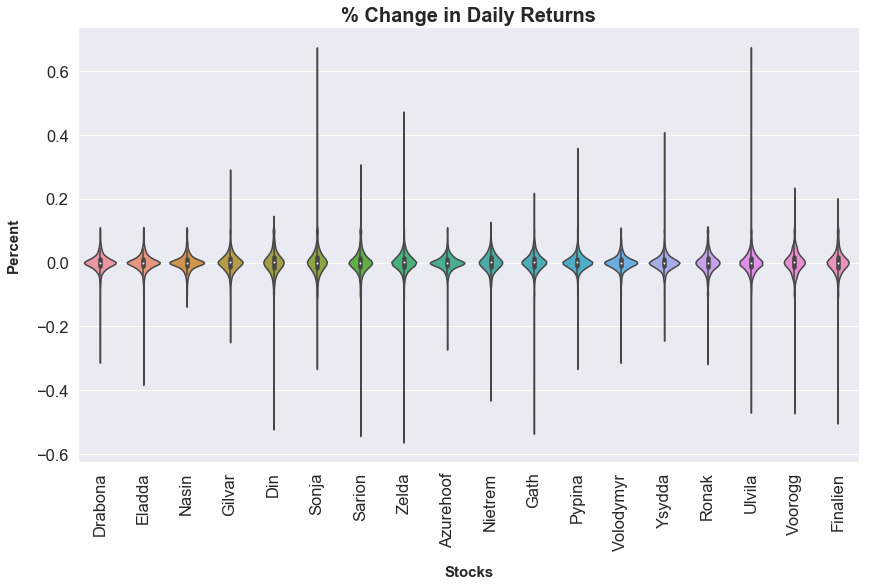

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.violinplot(x='variable', y='value', data=pd.melt(returns)).set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.xlabel('Stocks', fontsize=15, fontweight='bold', labelpad=15) 
plt.ylabel('Percent', fontsize=15, fontweight='bold', labelpad=15)
plt.title('% Change in Daily Returns', fontsize=20, fontweight='bold')

It would be more useful to create box and violin plots for average annual returns of each stock instead of daily returns. I have decided to forgo that because average annual returns are not very germane to this study.

It looks like we have a number of highly volatile stocks, namely Sonja, Sarion, Zelda, Gath, and Ulvila. We can observe that from extended data points on both plots. This shows high variability which, in turn, translates to volatility in the stock returns. But the above graphs don't really tell us that much. Let's check the distribution of the returns of each stock.

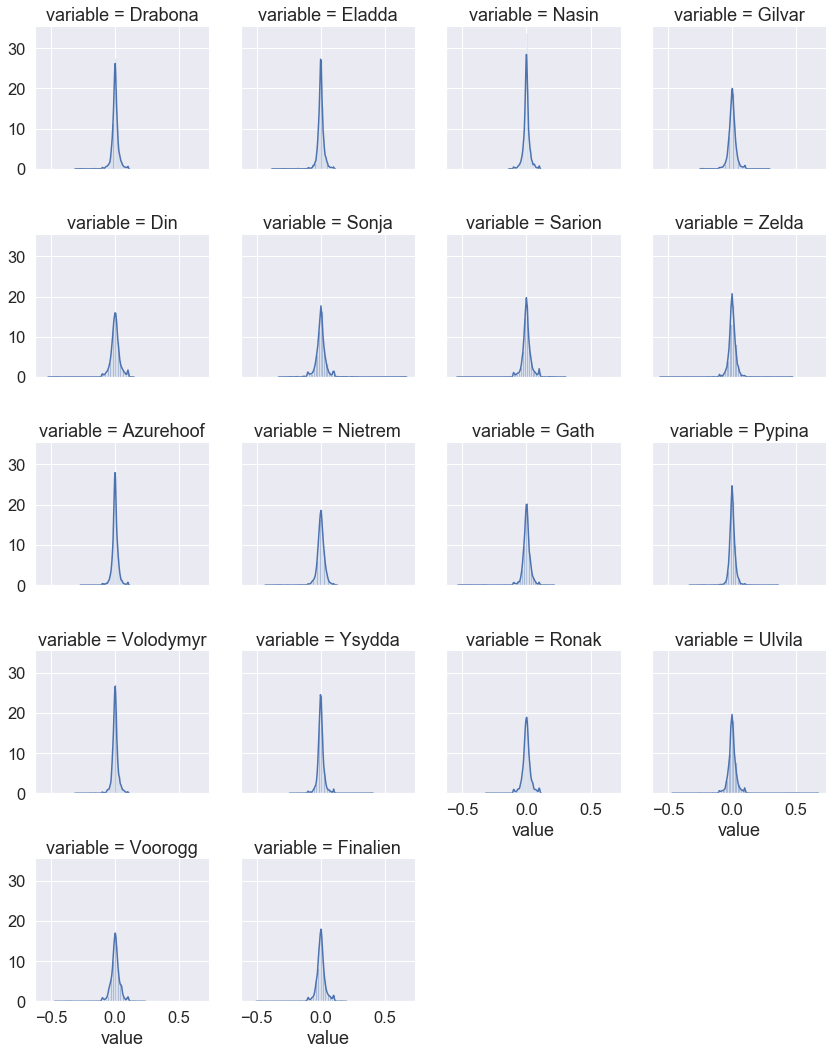

In [20]:
sns.FacetGrid(data=pd.melt(returns), col='variable', col_wrap=4).map(sns.distplot, 'value')

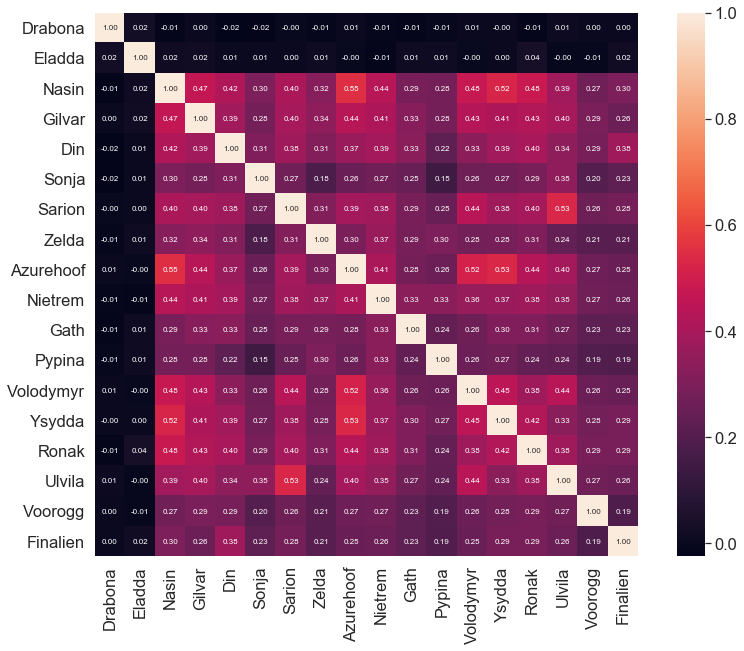

In [21]:
#plotting stocks returns correlation heatmap
corrmat = returns.corr()
cm = np.corrcoef(returns.values.T)
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(14, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size':8},
                 yticklabels=returns.columns, xticklabels=returns.columns
                )

In [22]:
#define function to compute daily cumulative returns
def compute_cum_returns(df):
    cum_returns = (1 + df).cumprod() - 1
    return cum_returns

#get the cumulative returns with the above defined function
cum_daily_returns = compute_cum_returns(returns)
cum_daily_returns.head()

,Drabona,Eladda,Nasin,Gilvar,Din,Sonja,Sarion,Zelda,Azurehoof,Nietrem,Gath,Pypina,Volodymyr,Ysydda,Ronak,Ulvila,Voorogg,Finalien
Date,,,,,,,,,,,,,,,,,,
2004-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-01-05,0.050476,0.055324,0.057931,0.100219,0.026042,0.037866,0.005128,0.060606,0.092131,0.014493,-0.009705,0.048035,0.045956,0.099515,0.068898,0.036341,0.042162,0.026175
2004-01-06,0.081905,0.090814,0.064828,0.109729,0.071615,0.017212,0.044872,0.096970,0.074856,0.004348,-0.030380,0.070266,0.083640,0.184466,0.112205,0.050125,0.072432,0.069007
2004-01-07,0.100952,0.154489,0.077241,0.097293,0.059896,0.055077,0.037179,0.114286,0.074856,0.016667,0.004641,0.069869,0.096507,0.160194,0.110236,0.083960,0.052973,0.088638
2004-01-08,0.107619,0.113779,0.064828,0.117045,0.065104,0.058520,0.064103,0.116883,0.071017,0.061594,-0.000844,0.088527,0.107537,0.199029,0.137795,0.086466,0.128649,0.060678


(array([731581., 732312., 733042., 733773., 734503., 735234., 735964.,
        736695.]), <a list of 8 Text xticklabel objects>)

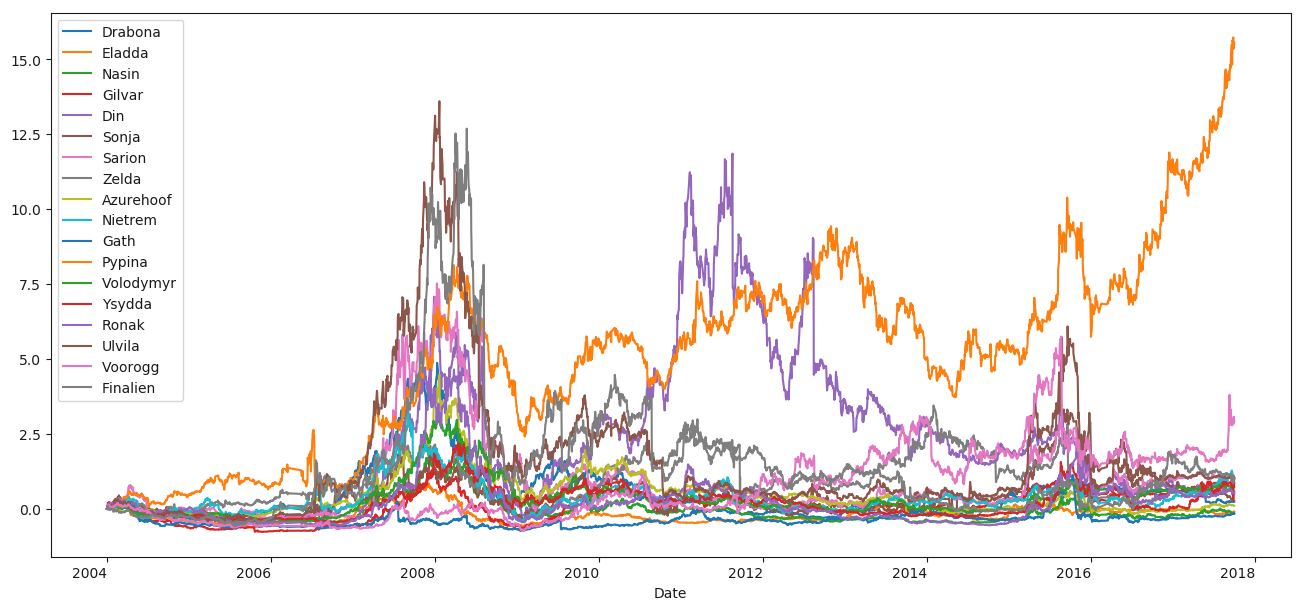

In [23]:
#visualizing cum_daily_returns
plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots(figsize=(16, 8))
cum_daily_returns.plot(ax=ax) ; plt.xticks(rotation=None)

I want to assemble all these stocks into an equally weighted portfolio to test the ML trading strategy later:

In [24]:
#create an equally-weighted portfolio
portfolio = returns.sum(axis=1)
portfolio.head()

Date
2004-01-02    0.000000
2004-01-05    0.857592
2004-01-06    0.389463
2004-01-07    0.181207
2004-01-08    0.183186
dtype: float64

(array([731581., 732312., 733042., 733773., 734503., 735234., 735964.,
        736695.]), <a list of 8 Text xticklabel objects>)

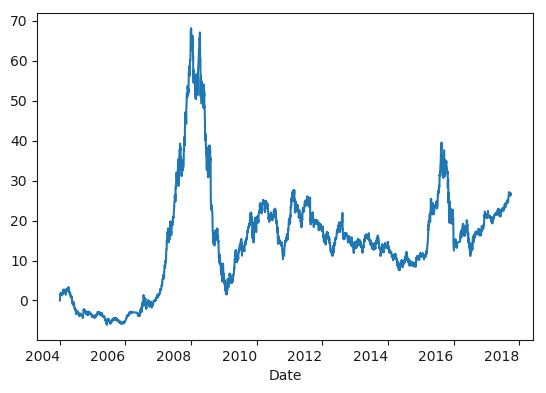

In [25]:
#calculate and plot portofolio cumulative returns
portfolio_cum = (returns + 1).cumprod() - 1
portfolio_cum = portfolio_cum.sum(axis=1)
portfolio_cum.plot() ; plt.xticks(rotation=None)

## Trading stocks with machine learning

Before I begin, I must credit Varun Divakar for his <a href='https://www.quantinsti.com/blog/trading-using-machine-learning-python-svm-support-vector-machine/'>great posts</a> on using machine learning as trading strategies. I do not claim ownership of much of this code. With that being said there are some serious flaws with his trading techniques.

In [26]:
#import libraries
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import mixture as mix

Predicting asset returns are extremely difficult. Traditional methods, such as the ARIMA model, require the time series data to be <a href='https://people.duke.edu/~rnau/411diff.htm'>stationary</a>, meaning the statistical propoerties, such mean, variance, autocorrelation, etc. are all constant over time. We know from our data that our stocks do not exhibit any stationarity. For this reason, knowing their mean returns, variances, and correlations do no tell us anything about how the stock will perform in the future. Therefore, we cannot use any regression models to make any future predictions for our stocks.

<a href='https://www.quantinsti.com/blog/mixture-models-for-forecasting-asset-returns/'>So what can we do?</a> We need a model that can:
    <b>a)</b> Adapt to non-stationary processes (stock prices/returns); and
    <b>b)</b> Provides a reasonable approximation of the linear process that is generating the data.
    
This is where <b>mixture models</b> come in. Mixture models are based on several well-established concepts, such as Markov and Hidden Markov models, and Expectation-Maximization (EM) algorithm. To apply a mixture model to our data, we can consider our stock returns as a sequence of states or <i>regimes</i> (caution: these regimes are distinct from the bullish/bearish market regimes which I employ in my thesis). In this mixture model, each regime is characterized by its own statistics, such as mean and volatility, assuming that stock returns will transition between these regimes based on probability.

In this exercise, I employ the Gaussian mixture model (GMM), which is a probabilistic model for representing normally distribution subpopulations or clusters within an overall population. GMM learns these clusters by using the EM algorithm to make a "soft" assignment of each data point to their corresponding clusters (<a href='https://web.stanford.edu/~hastie/ElemStatLearn/'>source</a>, pp 463). In other words, GMM employs the EM algorithm to generate the most likely sequence of regimes. Hence, GMM is an unsupervised model. For a more technical primer, read <a href='https://brilliant.org/wiki/gaussian-mixture-model/'>this</a> wiki on GMM

With a basic understanding of whats going on with our model, lets now get back to coding:

In [27]:
#split the data to train and test sets
split = int(0.75*len(returns))

train = returns[:split]
test = returns[split:]

In [28]:
train.head()

,Drabona,Eladda,Nasin,Gilvar,Din,Sonja,Sarion,Zelda,Azurehoof,Nietrem,Gath,Pypina,Volodymyr,Ysydda,Ronak,Ulvila,Voorogg,Finalien
Date,,,,,,,,,,,,,,,,,,
2004-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-01-05,0.050476,0.055324,0.057931,0.100219,0.026042,0.037866,0.005128,0.060606,0.092131,0.014493,-0.009705,0.048035,0.045956,0.099515,0.068898,0.036341,0.042162,0.026175
2004-01-06,0.029918,0.033630,0.006519,0.008644,0.044416,-0.019900,0.039541,0.034286,-0.015817,-0.010000,-0.020878,0.021212,0.036028,0.077263,0.040516,0.013301,0.029046,0.041739
2004-01-07,0.017606,0.058373,0.011658,-0.011206,-0.010936,0.037225,-0.007362,0.015785,0.000000,0.012266,0.036118,-0.000371,0.011874,-0.020492,-0.001770,0.032220,-0.018145,0.018364
2004-01-08,0.006055,-0.035262,-0.011524,0.018000,0.004914,0.003263,0.025958,0.002331,-0.003571,0.044191,-0.005460,0.017440,0.010059,0.033473,0.024823,0.002312,0.071869,-0.025683


In [29]:
test.head()

,Drabona,Eladda,Nasin,Gilvar,Din,Sonja,Sarion,Zelda,Azurehoof,Nietrem,Gath,Pypina,Volodymyr,Ysydda,Ronak,Ulvila,Voorogg,Finalien
Date,,,,,,,,,,,,,,,,,,
2014-04-25,-0.003040,0.003836,-0.002564,0.007669,-0.017333,-0.000003,-0.011938,0.015439,-0.017857,0.006316,-0.000572,-0.001408,0.005736,0.003247,-0.007634,-0.015536,-0.011989,-0.007437
2014-04-28,-0.017276,-0.024204,-0.015424,0.019787,-0.011759,-0.007673,0.004647,0.040277,-0.002273,-0.007845,-0.012027,-0.009622,0.010456,-0.012945,0.000000,0.003322,0.009377,-0.039193
2014-04-29,0.013444,-0.002611,-0.010444,-0.025373,-0.015561,-0.004538,-0.027752,-0.038205,0.002278,-0.016869,-0.032464,-0.000503,0.006585,-0.009836,-0.007692,-0.021523,0.010929,-0.012597
2014-04-30,-0.003061,0.019634,-0.002639,0.000000,-0.000465,-0.000036,-0.030447,0.039989,0.004545,0.001609,-0.021570,-0.000587,0.009346,-0.006623,-0.003876,-0.025381,-0.030270,0.001823
2014-05-05,-0.003071,-0.012837,0.015873,-0.003828,0.008837,-0.000194,-0.002944,-0.014355,0.013575,-0.021413,-0.009798,0.005198,0.007407,0.003333,0.000000,-0.008681,-0.052397,-0.001213


In [30]:
#initiate the GMM model that will divide the market into 2 regimes
#with more data, the number of regimes could be increased
#an alternative would be to use BIC criterion to select the number of components
model = mix.GaussianMixture(n_components=2, covariance_type='spherical',
                           n_init=100, random_state=123) 

In [31]:
#fit the model to the data and predict the regimes
scaler = StandardScaler()
model.fit(np.reshape(scaler.fit_transform(train), (-1, returns.shape[1])))
regime = model.predict(np.reshape(scaler.fit_transform(test), (-1, returns.shape[1])))

In [32]:
#check that regimes have been successfully predicted for the test data
regime[1:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0], dtype=int64)

In [33]:
#create another column of the sum of daily returns for the test set
test['Port_Return'] = test.sum(axis=1) #sum row-wise across each column

Regimes = pd.DataFrame(regime, columns=['Regime'], index=test.index)\
            .join(test, how='inner')\
                .assign(market_cu_return=test\
                        .Port_Return.cumsum())\
                        .reset_index(drop=False)\
                        .rename(columns={'index':'Date'})
#Note: Calculating cumulative returns with cumsum() is probably incorrect
#Cumulative returns: (returns + 1).cumprod() - 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
Regimes.head()

,Date,Regime,Drabona,Eladda,Nasin,Gilvar,Din,Sonja,Sarion,Zelda,...,Gath,Pypina,Volodymyr,Ysydda,Ronak,Ulvila,Voorogg,Finalien,Port_Return,market_cu_return
0,2014-04-25,1,-0.003040,0.003836,-0.002564,0.007669,-0.017333,-0.000003,-0.011938,0.015439,...,-0.000572,-0.001408,0.005736,0.003247,-0.007634,-0.015536,-0.011989,-0.007437,-0.055068,-0.055068
1,2014-04-28,1,-0.017276,-0.024204,-0.015424,0.019787,-0.011759,-0.007673,0.004647,0.040277,...,-0.012027,-0.009622,0.010456,-0.012945,0.000000,0.003322,0.009377,-0.039193,-0.072376,-0.127443
2,2014-04-29,1,0.013444,-0.002611,-0.010444,-0.025373,-0.015561,-0.004538,-0.027752,-0.038205,...,-0.032464,-0.000503,0.006585,-0.009836,-0.007692,-0.021523,0.010929,-0.012597,-0.192733,-0.320176
3,2014-04-30,1,-0.003061,0.019634,-0.002639,0.000000,-0.000465,-0.000036,-0.030447,0.039989,...,-0.021570,-0.000587,0.009346,-0.006623,-0.003876,-0.025381,-0.030270,0.001823,-0.048008,-0.368184
4,2014-05-05,1,-0.003071,-0.012837,0.015873,-0.003828,0.008837,-0.000194,-0.002944,-0.014355,...,-0.009798,0.005198,0.007407,0.003333,0.000000,-0.008681,-0.052397,-0.001213,-0.076507,-0.444691


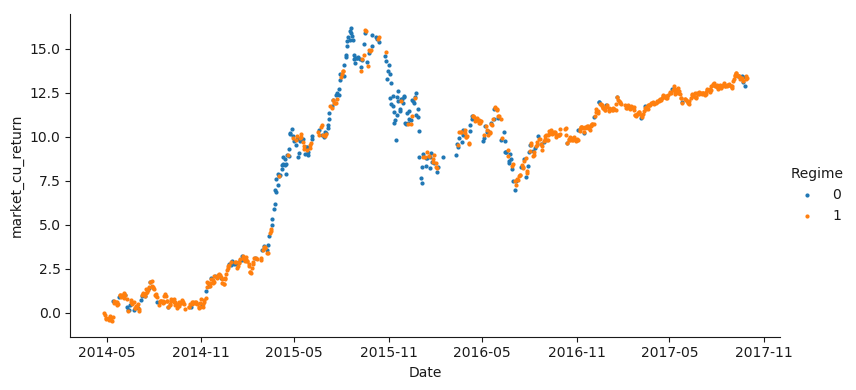

In [35]:
order = [0, 1]
fig = sns.FacetGrid(data=Regimes, hue='Regime', hue_order=order,
                    aspect=2, height=4)
fig.map(plt.scatter, 'Date', 'market_cu_return', s=4).add_legend()

In [36]:
for i in order:
    print('Mean for regime %i: '%i, model.means_[i][0])
    print('Covariance for regime %i: '%i, (model.covariances_[i]))

Mean for regime 0:  -0.0040690435317471884
Covariance for regime 0:  2.2715021418682753
Mean for regime 1:  0.0018733876234143436
Covariance for regime 1:  0.4134207939230413


Because the data is limited, I had to cut the regimes to only 2. We can interpret the regimes like this (in relative terms only):

1) Regime 0: Low mean, high covariance <br>
2) Regime 1: High mean, low covariance

Now that we have our regimes, we can finally get to implementing our trading model, the Support Vector Classifier (SVC):

In [37]:
#scaling the Regimes df to train SVC and create a signals column
columns = Regimes.columns.drop(['Regime', 'Date'])
Regimes[columns] = scaler.fit_transform(Regimes[columns])
Regimes['Signal'] = 0
Regimes.loc[Regimes['Port_Return'] > 0, 'Signal'] = 1
Regimes.loc[Regimes['Port_Return'] < 0, 'Signal'] = -1

In [38]:
#initiate the classifier
classifier = SVC(C=2.0, cache_size=100, class_weight=None, coef0=0.0,
                decision_function_shape=None, degree=3, gamma='auto',
                kernel='rbf', max_iter=-1, probability=False,
                random_state=None, shrinking=True, tol=0.001,
                verbose=False)

In [39]:
#split and train the Regimes df again
split2 = int(0.8*len(Regimes))

X = Regimes.drop(['Signal', 'Port_Return', 'market_cu_return', 'Date'], axis=1)
y = Regimes['Signal']

#fit the classifer
classifier.fit(X[:split2], y[:split2])

SVC(C=2.0, cache_size=100, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
#create another column of the sum of daily returns for entire portfolio
returns['Port_Return'] = returns.sum(axis=1)
returns.head()

,Drabona,Eladda,Nasin,Gilvar,Din,Sonja,Sarion,Zelda,Azurehoof,Nietrem,Gath,Pypina,Volodymyr,Ysydda,Ronak,Ulvila,Voorogg,Finalien,Port_Return
Date,,,,,,,,,,,,,,,,,,,
2004-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-01-05,0.050476,0.055324,0.057931,0.100219,0.026042,0.037866,0.005128,0.060606,0.092131,0.014493,-0.009705,0.048035,0.045956,0.099515,0.068898,0.036341,0.042162,0.026175,0.857592
2004-01-06,0.029918,0.033630,0.006519,0.008644,0.044416,-0.019900,0.039541,0.034286,-0.015817,-0.010000,-0.020878,0.021212,0.036028,0.077263,0.040516,0.013301,0.029046,0.041739,0.389463
2004-01-07,0.017606,0.058373,0.011658,-0.011206,-0.010936,0.037225,-0.007362,0.015785,0.000000,0.012266,0.036118,-0.000371,0.011874,-0.020492,-0.001770,0.032220,-0.018145,0.018364,0.181207
2004-01-08,0.006055,-0.035262,-0.011524,0.018000,0.004914,0.003263,0.025958,0.002331,-0.003571,0.044191,-0.005460,0.017440,0.010059,0.033473,0.024823,0.002312,0.071869,-0.025683,0.183186


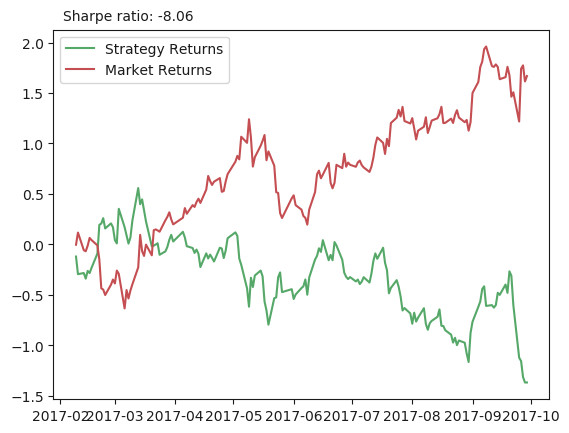

In [41]:
#split the data
p_data = len(X)-split2

#add the predicted signal to the entire dataset
returns['Pred_Signal'] = 0
returns.iloc[-p_data: , returns.columns.get_loc('Pred_Signal')] = classifier.predict(X[split2:])

#get the daily returns of the strategy
returns['str_ret'] = returns['Pred_Signal'] * returns['Port_Return'].shift(-1)
returns.fillna(0, inplace=True)

#get the cumulative returns of the strategy
returns['strategy_cu_return'] = 0
returns['market_cu_return'] = 0
returns.iloc[-p_data: , returns.columns.get_loc('strategy_cu_return')]\
    = np.nancumsum(returns['str_ret'][-p_data:])
returns.iloc[-p_data: , returns.columns.get_loc('market_cu_return')]\
    = np.nancumsum(returns['Port_Return'][-p_data:])
Sharpe = (returns['strategy_cu_return'][-1] - returns['market_cu_return'][-1])\
    / np.nanstd(returns['strategy_cu_return'][-p_data:])

#plot strategy performance
plt.plot(returns['strategy_cu_return'][-p_data:], color='g', label='Strategy Returns')
plt.plot(returns['market_cu_return'][-p_data:], color='r', label='Market Returns')
plt.figtext(0.14, 0.9, s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()

Looks like this is not a very good strategy for trading on a portfolio :(

But the strange thing about this strategy is that it only works for certain assets. The tricky and unknown part is what makes this strategy work for some stocks and why. For example, we can apply this strategy on the just one stock to get some quite good returns:

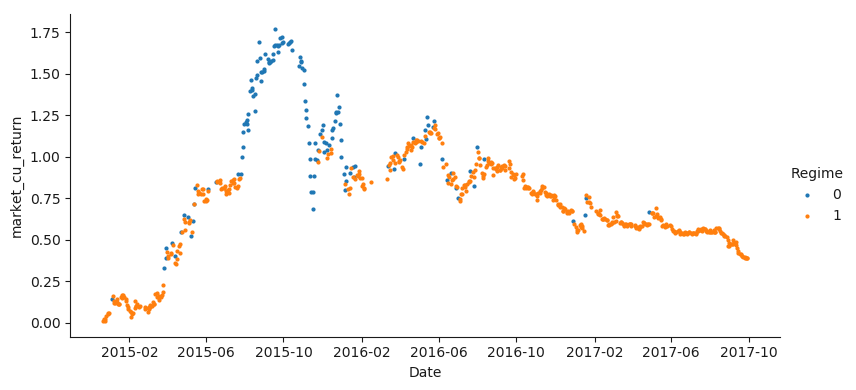

Mean for regime 0:  0.8565753524312082
Covariance for regime 0:  1.9928749646024078
Mean for regime 1:  -0.38519146187525527
Covariance for regime 1:  0.31171543780029515


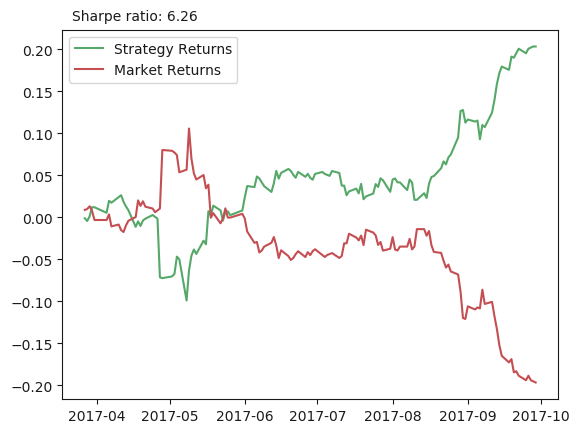

In [42]:
stock = pd.DataFrame(stocks['Sonja'])
stock['Return'] = stock.pct_change()
stock.fillna(0, inplace=True)

#define train/test ratios
n=10
t=0.8
split = int(t*len(stock))

#initiate mixture model
model = mix.GaussianMixture(n_components=2, 
                            covariance_type='spherical',
                            n_init=100,
                            random_state=0)

#fit the model to the data
scaler = StandardScaler()
model.fit(np.reshape(scaler.fit_transform(stock[:split]), (-1, stock.shape[1])))
regime = model.predict(np.reshape(scaler.fit_transform(stock[split:]), (-1, stock.shape[1])))

#create the regimes dataframe and add othe required columns
Regimes = pd.DataFrame(regime, columns=['Regime'], index=stock[split:].index)\
            .join(stock[split:], how='inner')\
                .assign(market_cu_return=stock[split:]\
                        .Return.cumsum())\
                        .reset_index(drop=False)\
                        .rename(columns={'index':'Date'})
   
#visualize the GMM model's results                     
order = [0, 1]
fig = sns.FacetGrid(data=Regimes, hue='Regime', hue_order=order,
                    aspect=2, height=4)
fig.map(plt.scatter, 'Date', 'market_cu_return', s=4).add_legend()
plt.show()

#print mean and covariance of each regime
for i in order:
    print('Mean for regime %i: '%i, model.means_[i][0])
    print('Covariance for regime %i: '%i, (model.covariances_[i]))
    
#scaling the Regimes df to train SVC and create signal column    
columns = Regimes.columns.drop(['Regime', 'Date'])
Regimes[columns] = scaler.fit_transform(Regimes[columns])
Regimes['Signal'] = 0
Regimes.loc[Regimes['Return'] > 0, 'Signal'] = 1
Regimes.loc[Regimes['Return'] < 0, 'Signal'] = -1

#initiate classifier
classifier = SVC(C=2.0, cache_size=100, class_weight=None, coef0=0.0,
                decision_function_shape=None, degree=2, gamma='auto',
                kernel='rbf', max_iter=-1, probability=False,
                random_state=None, shrinking=True, tol=0.001,
                verbose=False)

#split and fit the classifier
split2 = int(0.8 * len(Regimes))

X = Regimes.drop(['Signal', 'Return', 'market_cu_return', 'Date'], axis=1)
y = Regimes['Signal']

classifier.fit(X[:split2], y[:split2])

#----------
p_data = len(X)-split2

stock['Pred_Signal'] = 0
stock.iloc[-p_data: , stock.columns.get_loc('Pred_Signal')] = classifier.predict(X[split2:])

stock['str_ret'] = stock['Pred_Signal'] * stock['Return'].shift(-1)
stock.fillna(0, inplace=True)

stock['strategy_cu_return'] = 0
stock['market_cu_return'] = 0
stock.iloc[-p_data: , stock.columns.get_loc('strategy_cu_return')]\
    = np.nancumsum(stock['str_ret'][-p_data:])
stock.iloc[-p_data: , stock.columns.get_loc('market_cu_return')]\
    = np.nancumsum(stock['Return'][-p_data:])
Sharpe = (stock['strategy_cu_return'][-1] - stock['market_cu_return'][-1])\
    / np.nanstd(stock['strategy_cu_return'][-p_data:])
    
plt.plot(stock['strategy_cu_return'][-p_data:], color='g', label='Strategy Returns')
plt.plot(stock['market_cu_return'][-p_data:], color='r', label='Market Returns')
plt.figtext(0.14, 0.9, s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()

## Conclusion

I tested this strategy with a couple of other individual stocks, and there was strange pattern: The strategy and market returns are like mirror images of each other along a horiztonal axis, as if the strategy was just multiplying the market returns with a negative sign and returning us the result. Only minor variations can be observed. This property begs further investigation.

Our results from this strategy are not very hopeful and, therefore, we can conclude that this is not a very good trading strategy. In the latter stages, we also broke down our data into very small training and test sets which might also have contributed to bad results. 

I try to improve and simplity the approach used here in <a href='http://nbviewer.jupyter.org/github/alisiina/finance/blob/master/mixture_model/Alternative%20Method%20with%20GMM%20Only.ipynb'>another notebook</a>, with seemingly more hopeful results.